In [1]:
# https://github.com/higgsfield/RL-Adventure/blob/master/1.dqn.ipynb
# DQN without a frozen target network

In [2]:
%matplotlib inline
# %load_ext memory_profiler
# %load_ext line_profiler
# %load_ext heat
# %load_ext snakeviz

In [3]:
import yaml
import datetime

# from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
from torch.utils.tensorboard import SummaryWriter
# %reload_ext tensorboard
# %tensorboard --port=9706 --logdir ./runs
from torchsummary import summary

In [5]:
experiment_no = 'base_config'
# FROM CONFIG FILE
config_path =  './' + experiment_no + '.yaml' # sys.argv[2]
config = yaml.safe_load(open(config_path,'r'))

seed_value = 324267 # sys.argv[1]

# # Writer will output to ./runs/ directory by default
writer_dir = './runs/' + config['MODEL_NAME'] + '_' + experiment_no + '_' + str(seed_value) + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(writer_dir)
print("EXPERIMENT: ", experiment_no, "\tSEED: ", seed_value, "\twriter_dir: ", writer_dir)

EXPERIMENT:  base_config 	SEED:  324267 	writer_dir:  ./runs/D1QN_base_config_324267_20190822-080337


In [6]:
import math
import os 
import random 
import numpy as np 
import tensorflow as tf 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [7]:
os.environ['PYTHONHASHSEED']=str(seed_value) 
random.seed(seed_value) 
np.random.seed(seed_value) 
tf.random.set_seed(seed_value)
torch.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
import gym
# CartPole-v0 Environment
env_id = "CartPole-v0"
env = gym.make(env_id)
env.seed(seed_value);

In [9]:
USE_GPU = config['USE_GPU']

# Use CUDA
USE_CUDA = torch.cuda.is_available() and USE_GPU

if USE_CUDA:
    torch.cuda.manual_seed(seed_value)
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [10]:
# REPLAY BUFFER

from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [11]:
class DQN(nn.Module): #base model
    def __init__(self, num_inputs, num_actions, HIDDEN_LAYER_WIDTH):
        super(DQN, self).__init__()
        
        self.action_dim = num_actions
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, HIDDEN_LAYER_WIDTH),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_WIDTH, HIDDEN_LAYER_WIDTH),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_WIDTH, num_actions)
        )

    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        with torch.no_grad():
            if random.random() > epsilon:
                state   = torch.tensor(state, dtype=torch.float32).unsqueeze(dim=0).to(device)
                q_values = self.forward(state)
                action  = q_values.max(dim=1)[1].item()
            else:
                action = random.randrange(self.action_dim)
        return action

In [12]:
# e-greedy exploration

epsilon_start = config['EPSILON_START']
epsilon_final = config['EPSILON_FINAL']
epsilon_decay = config['EPSILON_DECAY']

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

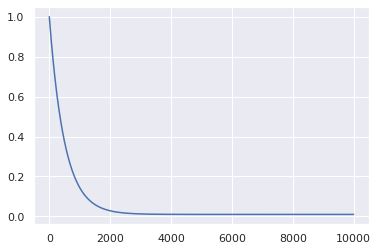

In [13]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

In [14]:
# MODEL
if (config['MODEL_NAME']=='D1QN'):
    # only one NN for estimating Q-values
    model = DQN(env.observation_space.shape[0], 
                 env.action_space.n,
                 config['HIDDEN_LAYER_WIDTH'])
    model = model.to(device)


elif (config['MODEL_NAME']=='DQN' or config['MODEL_NAME']=='D2QN'):
    # one inference model and one target model
    model = DQN(env.observation_space.shape[0], 
                 env.action_space.n,
                 config['HIDDEN_LAYER_WIDTH'])
    model = model.to(device)

    target = DQN(env.observation_space.shape[0], 
                 env.action_space.n,
                 config['HIDDEN_LAYER_WIDTH'])
    target = target.to(device)

    
else: #default model is D1QN
    # only one NN for estimating Q-values
    model = DQN(env.observation_space.shape[0], 
                 env.action_space.n,
                 config['HIDDEN_LAYER_WIDTH'])    
    model = model.to(device)


print(model)
summary(model, 
        input_size=(env.observation_space.shape[0],),
        batch_size=config['BATCH_SIZE'], 
        device='cuda' if USE_CUDA else 'cpu' )

DQN(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [32, 128]             640
              ReLU-2                  [32, 128]               0
            Linear-3                  [32, 128]          16,512
              ReLU-4                  [32, 128]               0
            Linear-5                    [32, 2]             258
Total params: 17,410
Trainable params: 17,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.07
Estimated Total Size (MB): 0.19
----------------------------------------------------

In [15]:
# OPTIMIZER
if (config['OPTIMIZER']=='Adam'):
    optimizer = optim.Adam(model.parameters(), 
                           lr=config['LEARNING_RATE'])
elif (config['OPTIMIZER']=='SGD'):
    optimizer = optim.SGD(model.parameters(), 
                           lr=config['LEARNING_RATE'])
else: #default optimizer is Adam
    optimizer = optim.Adam(model.parameters(), 
                           lr=config['LEARNING_RATE'])

In [16]:
# CRITERION
if (config['CRITERION']=='MSE'):
    criterion = nn.MSELoss()
elif (config['CRITERION']=='HUBER'):
    criterion = nn.SmoothL1Loss()
else: #default criterion is MSELoss
    criterion = nn.MSELoss()

In [17]:
# REPLAY BUFFER
replay_buffer = ReplayBuffer(capacity=config['REPLAY_BUFFER_SIZE'])

In [18]:
def update_target(current_model, target_model):
    target.load_state_dict(model.state_dict())
    
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.tensor(np.float32(state)      ,dtype=torch.float32).to(device)
    next_state = torch.tensor(np.float32(next_state) ,dtype=torch.float32, requires_grad=False).to(device)
    action     = torch.tensor(action                ,dtype=torch.long).to(device)
    reward     = torch.tensor(reward                ,dtype=torch.float32).to(device)
    done       = torch.tensor(done                  ,dtype=torch.float32).to(device)

    q_values = model(state)
    q_value  = q_values.gather(dim=1, index=action.unsqueeze(dim=1)).squeeze(dim=1)

    #next_q_value
    if (config['MODEL_NAME']=='D1QN'):
        next_q_values = model(next_state)
        next_q_value  = next_q_values.max(dim=1)[0]

    elif (config['MODEL_NAME']=='DQN'):
        next_q_values = target(next_state)
        next_q_value  = next_q_values.max(dim=1)[0]
        
    elif (config['MODEL_NAME']=='D2QN'):
        next_q_values = model(next_state) #all q-values from current model
        next_q_target_values = target(next_state) #all q-values from target model
        next_q_value = next_q_target_values.gather(dim=1, 
                                                  index=torch.max(next_q_values, dim=1)[1].unsqueeze(dim=1)).squeeze(dim=1)
        #q-values from target model by acting greedily on current model (double dqn)
        
    else: #Default is D1QN
        next_q_values = model(next_state)
        next_q_value  = next_q_values.max(dim=1)[0]
    
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = criterion(q_value, expected_q_value)
       
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.to('cpu')

In [19]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [20]:
if (config['MODEL_NAME']=='DQN' or config['MODEL_NAME']=='D2QN'):
    update_target(model, target)

In [ ]:
%%time

# Training
num_frames = config['TIMESTEPS']
batch_size = config['BATCH_SIZE']
gamma      = config['GAMMA']

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        writer.add_scalar('episode_reward', episode_reward, global_step=frame_idx)
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        writer.add_scalar('loss', loss.item(), global_step=frame_idx)
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                writer.add_histogram('model_'+ name, param.data, global_step=frame_idx)
                
        if (config['MODEL_NAME']=='DQN' or config['MODEL_NAME']=='D2QN'):
            for name, param in target.named_parameters():
                if param.requires_grad:
                    writer.add_histogram('target_'+ name, param.data, global_step=frame_idx)        
    
    if (config['MODEL_NAME']=='DQN' or config['MODEL_NAME']=='D2QN'):
        if frame_idx % config['TARGET_UPDATE_FREQ'] == 0:
            update_target(model, target)
            
writer.close()

In [ ]:
!jupyter nbconvert --to pdf dqn-cartpole.ipynb